In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os, zipfile, gdown
file_id="1fLKvOc2uohEcdimUemNsL05d4CND5qfq"
zip_path="/content/water_dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1fLKvOc2uohEcdimUemNsL05d4CND5qfq
From (redirected): https://drive.google.com/uc?id=1fLKvOc2uohEcdimUemNsL05d4CND5qfq&confirm=t&uuid=43a9e1b2-b6bf-440f-addc-a892a13986c8
To: /content/water_dataset.zip
100%|██████████| 68.7M/68.7M [00:00<00:00, 104MB/s]


'/content/water_dataset.zip'

In [3]:
extract_dir="/content/water_dataset"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_dir)

In [4]:
import glob
from PIL import Image
import numpy as np
image_dir="/content/water_dataset/data/images"
mask_dir="/content/water_dataset/data/labels"
image_paths=sorted(glob.glob(os.path.join(image_dir, "*tif")))
mask_paths=sorted(glob.glob(os.path.join(mask_dir, "*png")))
valid_pairs=[]
for img_path in image_paths:
  img_name=os.path.basename(img_path).replace(".tif","")
  mask_path=os.path.join(mask_dir, f"{img_name}.png")
  if not os.path.exists(mask_path):
    continue
  if "_" in os.path.basename(mask_path):
    continue
  mask=np.array(Image.open(mask_path))
  if np.max(mask)==0 or np.min(mask)==255:
    continue

  valid_pairs.append((img_path,mask_path))

print(len(valid_pairs), "valid pair")


261 valid pair


In [5]:
def calculate_water_index(img):
  R=img[:, :, 3].astype(np.float32)
  G=img[:, :, 2].astype(np.float32)
  B=img[:, :, 1].astype(np.float32)
  water_index=(G-R)/(G+R+1e-5)
  return np.expand_dims(water_index, axis=-1)

In [6]:
!pip install tifffile

In [7]:
import tifffile as tiff
def load_img_with_index(path):
  img=tiff.imread(path).astype(np.float32)/255.0
  if img.ndim==3 and img.shape[-1]==12:
    water_index=calculate_water_index(img)
    img=np.concatenate([img,water_index],axis=-1)
  return img

In [8]:
images=[]
masks=[]

for img_path, mask_path in valid_pairs:
  img=load_img_with_index(img_path)
  mask=np.array(Image.open(mask_path)).astype(np.uint8)

  if mask.ndim==3:
    mask=mask[:, :, 0]
  mask=np.expand_dims(mask, axis=-1)
  images.append(img)
  masks.append((mask))
images=np.array(images)
masks=np.array(masks)

print("Image Shape: ",images.shape)
print("Mask Shape: ",masks.shape)

Image Shape:  (261, 128, 128, 13)
Mask Shape:  (261, 128, 128, 1)


In [9]:
scaled_images=np.zeros_like(images)
for i in range(images.shape[0]):
  img=images[i]
  min_val=img.min(axis=(0,1), keepdims=True)
  max_val=img.max(axis=(0,1), keepdims=True)
  scaled_images[i]=(img-min_val)/(max_val-min_val+1e-8)
print("After Scaling min: ",scaled_images.min()," | max: ",scaled_images.max())
print("Final image shape: ",scaled_images.shape)
print("Final mask shape: ",masks.shape)

After Scaling min:  0.0  | max:  1.0
Final image shape:  (261, 128, 128, 13)
Final mask shape:  (261, 128, 128, 1)


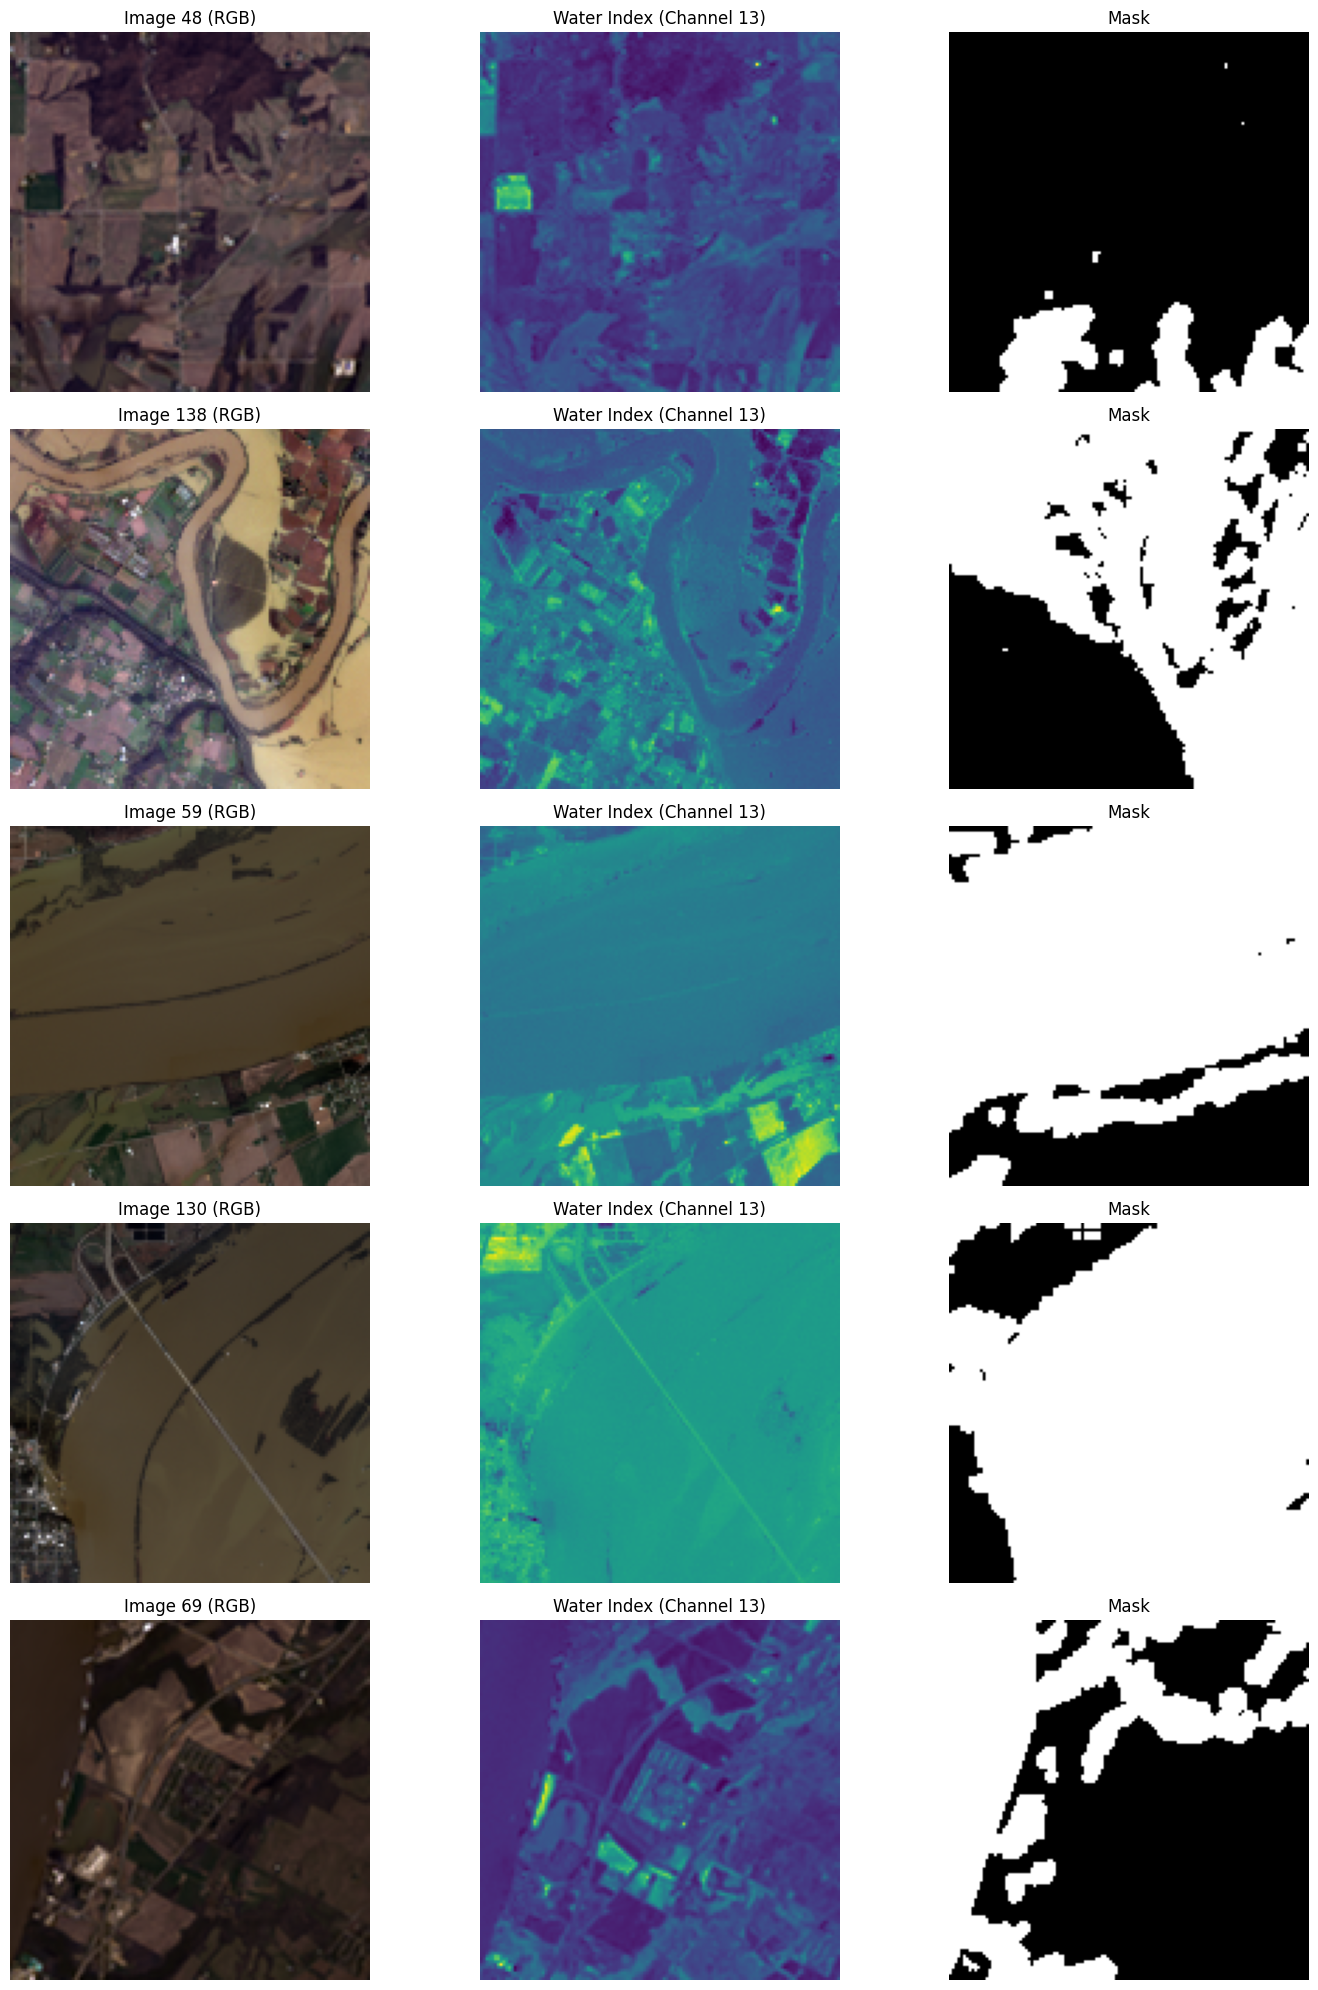

In [10]:
import matplotlib.pyplot as plt
import random
def display_sample_with_water_index(images, masks, num_samples=5, water_index_channel=12):
  plt.figure(figsize=(15, num_samples * 4))
  for i in range(num_samples):
    idx=random.randint(0, len(scaled_images)-1)
    img=scaled_images[idx][:, :, [3,2,1]]
    water_index=scaled_images[idx][:, :, water_index_channel]
    mask=masks[idx][:, :,0]

    plt.subplot(num_samples, 3, 3*i+1)
    plt.imshow(img)
    plt.title(f"Image {idx+1} (RGB)")
    plt.axis('off')

    plt.subplot(num_samples, 3, 3*i+2)
    plt.imshow(water_index, cmap='viridis', vmin=0, vmax=1)
    plt.title(f"Water Index (Channel {water_index_channel+1})")
    plt.axis('off')

    plt.subplot(num_samples, 3, 3*i+3)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

  plt.tight_layout()
  plt.show()

display_sample_with_water_index(scaled_images,masks)

In [11]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test=train_test_split(scaled_images, masks, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val=train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)
print("Train: ",X_train.shape, y_train.shape)
print("Validation: ",X_val.shape, y_val.shape)
print("Test: ",X_test.shape, y_test.shape)

Train:  (210, 128, 128, 13) (210, 128, 128, 1)
Validation:  (24, 128, 128, 13) (24, 128, 128, 1)
Test:  (27, 128, 128, 13) (27, 128, 128, 1)


In [12]:
!pip install segmentation-models

#Feature Extraction Approach#


In [13]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np

BACKBONE = 'efficientnetb0'
preprocess_input = sm.get_preprocessing(BACKBONE)

def build_pretrained_unet(input_shape=(128, 128, 13)):
    inp = Input(shape=input_shape)

    x = Conv2D(16, (3,3), padding='same')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(3, (3,3), padding='same')(x)

    base_model = sm.Unet(
        backbone_name=BACKBONE,
        input_shape=(128, 128, 3),
        encoder_weights='imagenet',
        classes=1,
        activation='sigmoid'
    )

    output = base_model(x)
    model = Model(inputs=inp, outputs=output)
    model.base_model = base_model
    return model

model = build_pretrained_unet()

model.compile(
    optimizer=Adam(1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score]
)

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=8,
)

Segmentation Models: using `tf.keras` framework.
Epoch 1/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - iou_score: 0.2167 - loss: 1.3624 - val_iou_score: 0.3189 - val_loss: 1.2030
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - iou_score: 0.3392 - loss: 1.1131 - val_iou_score: 0.4337 - val_loss: 1.1972
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - iou_score: 0.4186 - loss: 0.9391 - val_iou_score: 0.4543 - val_loss: 0.9595
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - iou_score: 0.4776 - loss: 0.8357 - val_iou_score: 0.4763 - val_loss: 0.9151
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - iou_score: 0.5103 - loss: 0.8039 - val_iou_score: 0.5083 - val_loss: 0.8730
Epoch 6/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - iou_score: 0.5547 - loss: 0.7120 - val_iou_score: 0.5074 - val_loss: 0.8237
Epoch 7/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - iou_score: 0.5829 - loss: 0.6605 - val_iou_score: 0.5242 - val_loss: 0.8026
Epoch 8/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/s

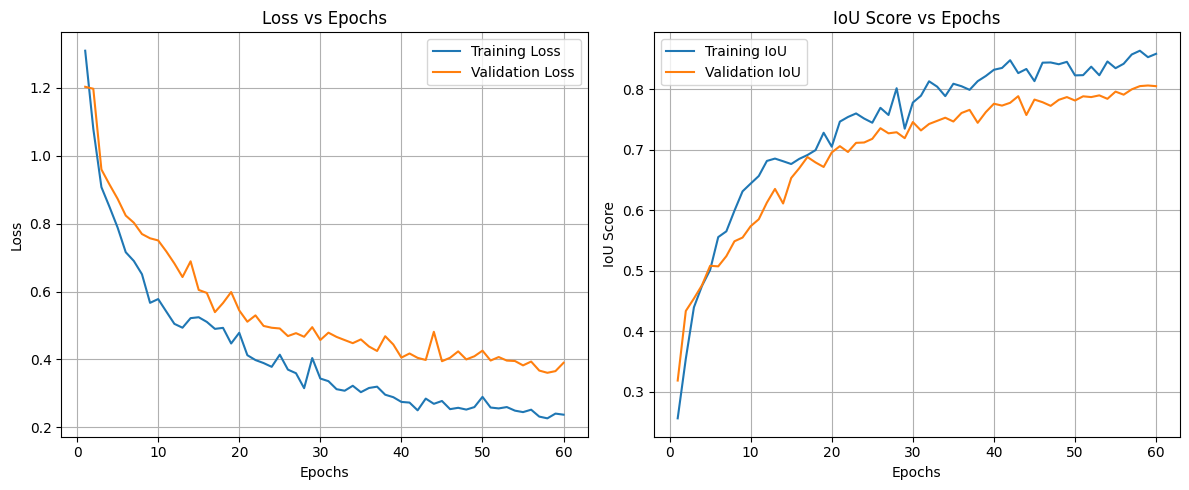

In [14]:
import matplotlib.pyplot as plt

# Extract training history
loss = history.history['loss']
val_loss = history.history['val_loss']
iou = history.history['iou_score']
val_iou = history.history['val_iou_score']

epochs = range(1, len(loss) + 1)

# Loss plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# IoU plot
plt.subplot(1, 2, 2)
plt.plot(epochs, iou, label='Training IoU')
plt.plot(epochs, val_iou, label='Validation IoU')
plt.title('IoU Score vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
results = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", results[0])
print("Test IoU Score:", results[1])


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - iou_score: 0.8192 - loss: 0.3403
Test Loss: 0.34031549096107483
Test IoU Score: 0.8192145824432373


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


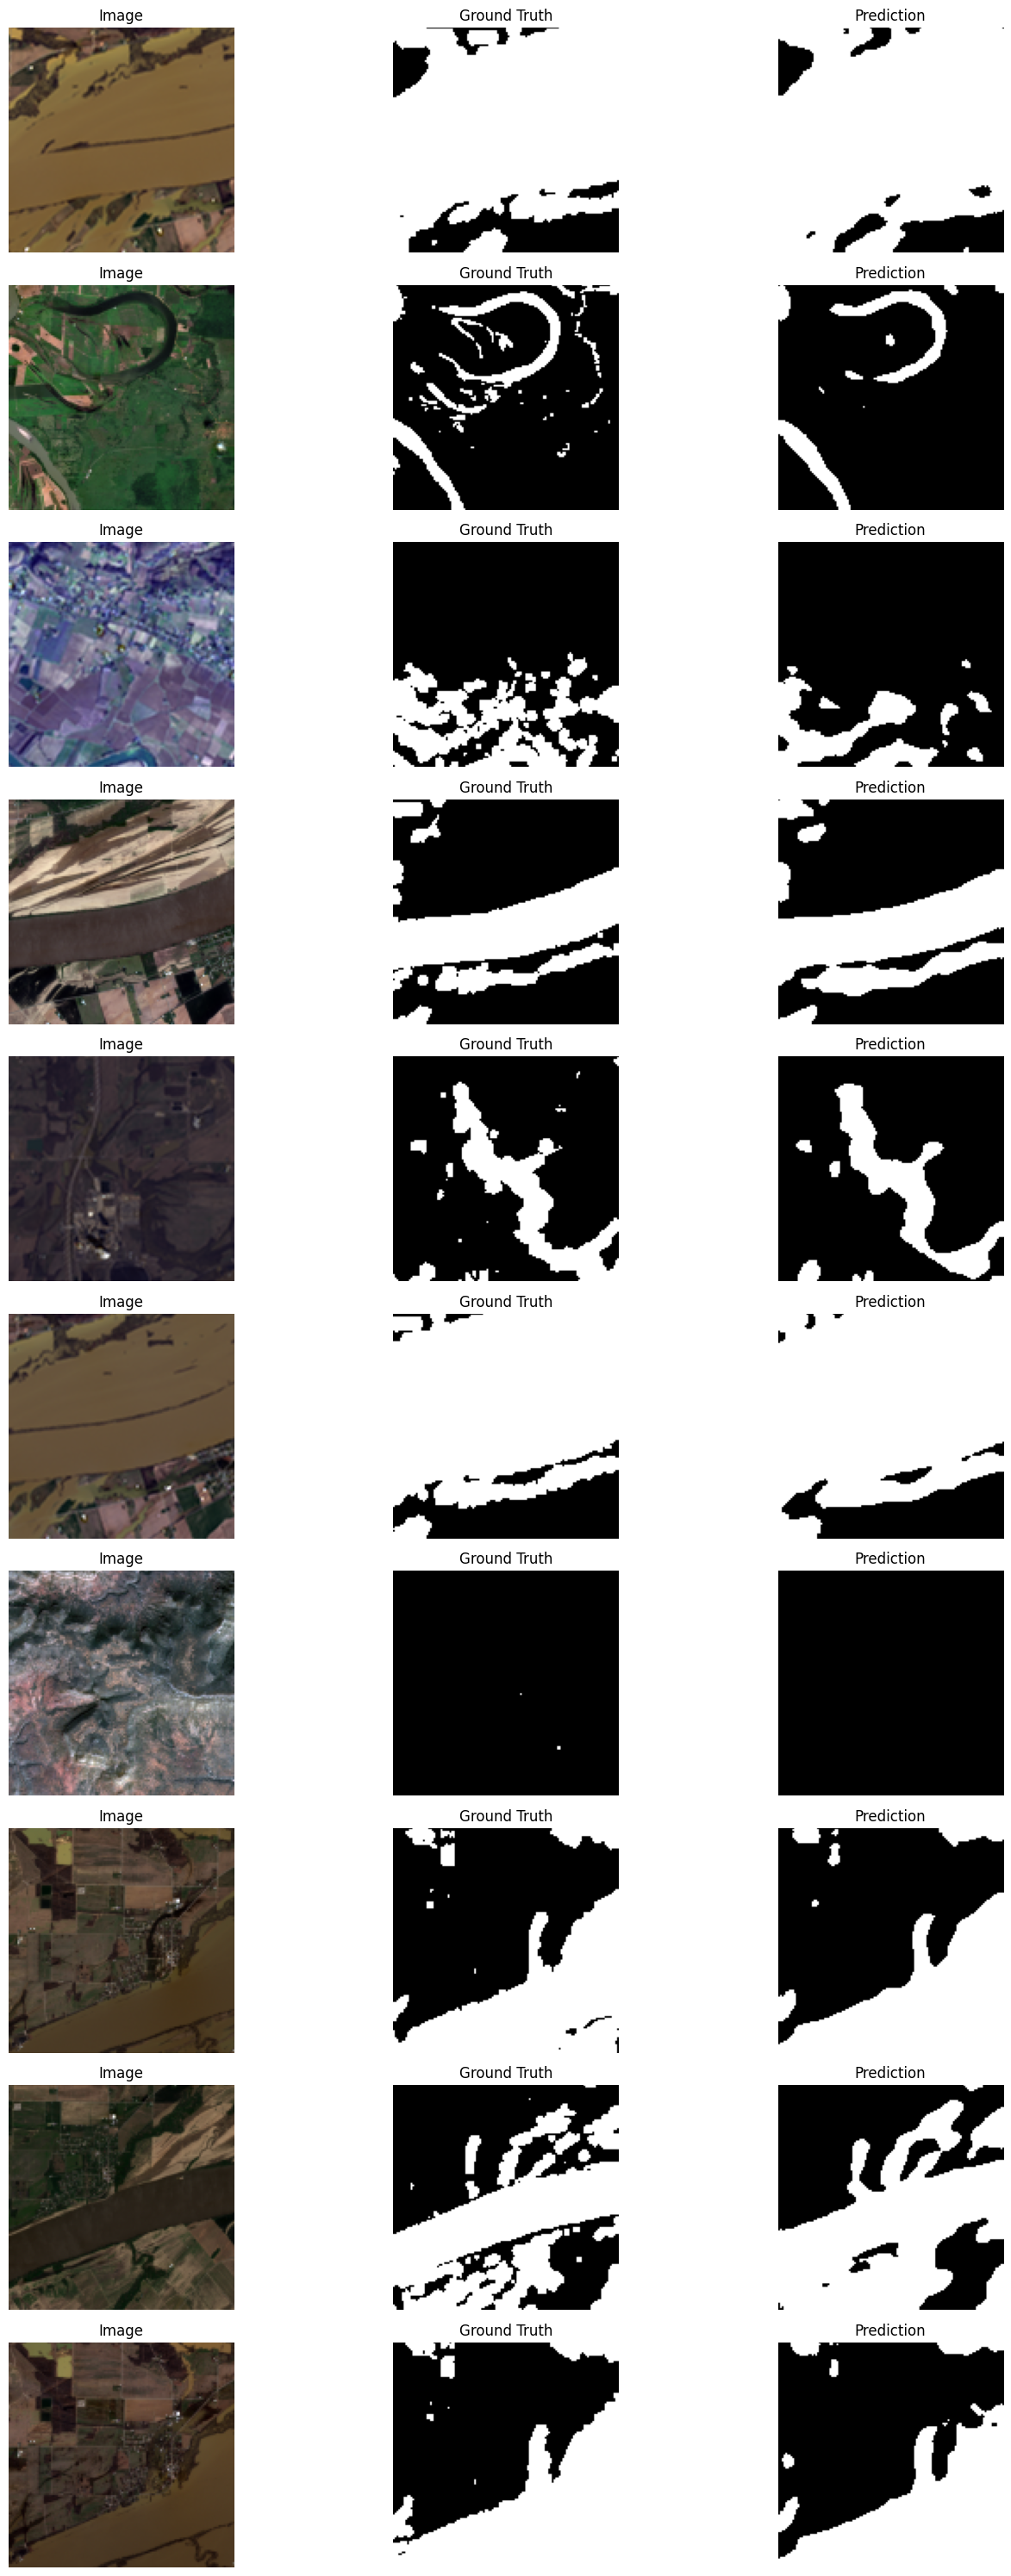

In [19]:
import matplotlib.pyplot as plt

def show_predictions(model, X, y_true, num_samples=5):
    indices = np.random.choice(len(X), num_samples, replace=False)
    preds = model.predict(X[indices])

    plt.figure(figsize=(15, num_samples * 3))

    for i, idx in enumerate(indices):
        img_rgb = X[idx][:,:, [3,2,1]]  # G B R -> visual
        mask_true = y_true[idx].squeeze()
        mask_pred = (preds[i].squeeze() > 0.5).astype(np.uint8)  # binary

        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img_rgb)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(mask_true, cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(mask_pred, cmap='gray')
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_predictions(model, X_test, y_test, num_samples=10)


In [ ]:
model.save('Freezed Segmentation Model.h5')

In [20]:
from keras.models import load_model
model= load_model('Freezed Segmentation Model.h5',compile=False)

#Fine Tuning Approach#

In [69]:
def build_FineTuned(input_shape=(128, 128, 13)):
    inp = Input(shape=input_shape)

    x = Conv2D(16, (3,3), padding='same')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(3, (3,3), padding='same')(x)

    base_model = sm.Unet(
        backbone_name=BACKBONE,
        input_shape=(128, 128, 3),
        encoder_weights='imagenet',
        classes=1,
        activation='sigmoid'
    )

    output = base_model(x)
    model = Model(inputs=inp, outputs=output)
    model.base_model = base_model
    return model
Tuned_Model = build_FineTuned()

In [71]:
encoder = Tuned_Model.get_layer("functional_30")

for layer in encoder.layers:
    layer.trainable = False

for layer in encoder.layers[-40:]:
    layer.trainable = True

Tuned_Model.compile(
    optimizer=Adam(1e-5),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score]
)
Tuned_Model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 128, 128, 13)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 16)   │         1,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 128, 128, 3)    │           435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_30 (Functional)      │ (None, 128, 128, 1)    │    10,115,501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,117,888 (38.60 MB)

 Trainable params: 6,066,308 (23.14 MB)

 Non-trainable params: 4,051,580 (15.46 MB)

In [72]:
history = Tuned_Model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    epochs=200
)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - iou_score: 0.2135 - loss: 1.4931 - val_iou_score: 0.2989 - val_loss: 1.5841
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - iou_score: 0.2262 - loss: 1.4739 - val_iou_score: 0.2933 - val_loss: 1.5563
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - iou_score: 0.2324 - loss: 1.4551 - val_iou_score: 0.2890 - val_loss: 1.5353
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - iou_score: 0.2428 - loss: 1.4374 - val_iou_score: 0.2855 - val_loss: 1.5180
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - iou_score: 0.2503 - loss: 1.4225 - val_iou_score: 0.2827 - val_loss: 1.5032
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - iou_score: 0.2407 - loss: 1.4201 - val_iou_score: 0.2802 - val_loss: 1.4905
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - iou_score: 0.2530 - loss: 1.4024 - val_iou_score: 0.2778 - val_loss: 1.4795
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - iou_score: 0.2613 - loss: 1.3828 - val_iou_sc

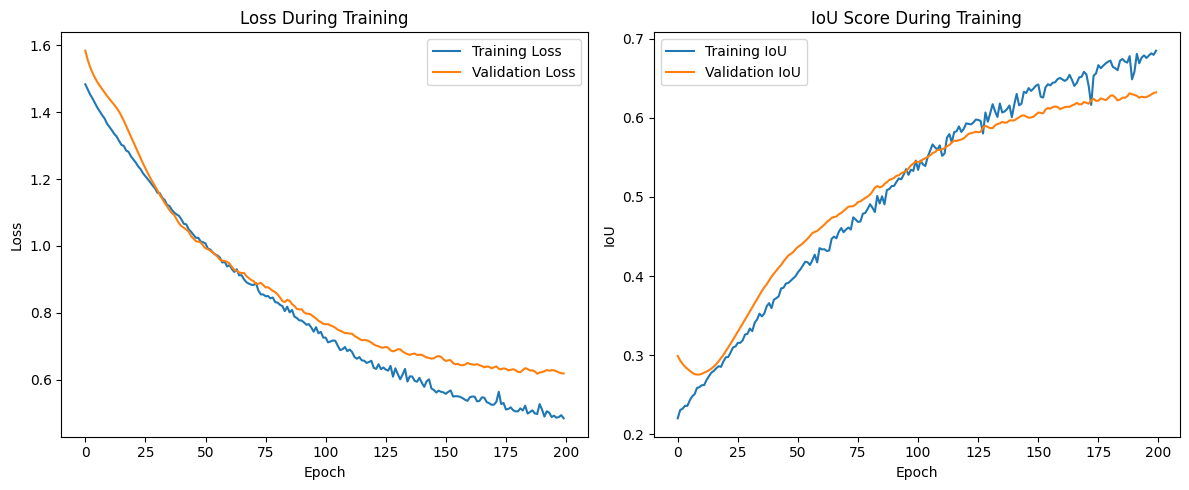

In [73]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['iou_score'], label='Training IoU')
    plt.plot(history.history['val_iou_score'], label='Validation IoU')
    plt.title('IoU Score During Training')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [75]:
results = Tuned_Model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", results[0])
print("Test IoU Score:", results[1])


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - iou_score: 0.6194 - loss: 0.5824
Test Loss: 0.5823687314987183
Test IoU Score: 0.6194009184837341


In [77]:
#I think the best model is the first one